# Vortex center glow

The aim of this simulation is to model the vortex center glow effect, which is caused to diffraction of the thermal emission from the environment outside the entrance pupil to the pupil image formed on the detector, by the vortex phase mask. 
To model the effect, several points outside the entrance pupil are taken and their intensity on the detector is evaluated. Net effect is determined by adding contributions from all these points.

### Imports

In [1]:
import heeps
from heeps.util.coord import cart_coord, polar_coord
from heeps.util.img_processing import resize_img, crop_img, pad_img, get_radial_profile
from heeps.optics import fp_mask, lyot_stop, detector
from copy import deepcopy
import proper
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import multiprocessing as mpro
from functools import partial
from sys import platform
import time
%matplotlib inline

### Input parameters

In [2]:
diam_ext_cold_stop = 40.944
diam_int_cold_stop = 7.363
diam_ext_eff = 37.812
diam_int_eff = 10.196
r_spot = 0.1 # m
ncrop = 101 # for psf visualization

### Initialize wavefront using PROPER

In [3]:
conf = dict(
    dir_current = '/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/VCG',
    band = 'L',
    mode = 'CVC',
    file_lyot_stop = 'pupil/ls_VCG_293.fits',
    cpu_count = None,
    hfov = 1,
    pupil_img_size = diam_ext_cold_stop + 2*r_spot,
    diam_ext = diam_ext_cold_stop, 
    diam_int = diam_int_cold_stop,
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
dir_current = conf['dir_current']
npupil = conf['npupil']
ngrid = conf['ngrid']
diam_ext = conf['diam_ext']
pupil_img_size = conf['pupil_img_size']
lam = conf['lam']
pscale = conf['pscale']
spi_width = conf['spi_width']
ndet = conf['ndet']
cpu_count = conf['cpu_count']
beam_ratio = npupil/ngrid*(diam_ext/pupil_img_size)
wf = proper.prop_begin(pupil_img_size, lam, ngrid, beam_ratio)

Simulation config: band=L, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2847
   npupil=293, pscale=5.47 mas, lam=3.8133E-06 m
   hfov=1.0 arcsec (-> ndet=365, 51.97 lam/D)



### Create cold stop

(293, 293)


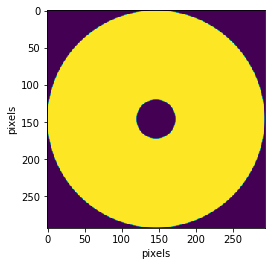

In [4]:
conf_stop = dict(conf, spi_width=0, seg_width=0)
cold_stop = heeps.pupil.create_pupil(**conf_stop)
print(cold_stop.shape)
plt.imshow(cold_stop), plt.xlabel('pixels'), plt.ylabel('pixels');
cold_stop = pad_img(cold_stop, ngrid)

### Create a spot

In [5]:
def create_spot(rad, theta, nimg=10526):
    x, y = cart_coord(nimg)
    x *= pupil_img_size/2
    y *= pupil_img_size/2
    c = (rad*np.cos(np.deg2rad(theta)), rad*np.sin(np.deg2rad(theta)))
    r =  np.abs((x-c[0]) + 1j*(y-c[1]))
    spot = (r <= r_spot)                    # create a spot
    spot = resize_img(spot, npupil)         # resize to npupil
    spot = pad_img(spot, ngrid)             # pad with zeros
    # normalize the entrance pupil intensity (total flux = 1)
    I_spot = spot**2
    spot = np.sqrt(I_spot/np.sum(I_spot))
    return spot

### Propagate functions

In [6]:
def propag_one_spot(rad, theta, verbose=False):
        #print(rad, theta)
        # keep a copy of the input wavefront
        wf1 = deepcopy(wf)
        # create a normalized spot
        spot = create_spot(rad, theta)
        # add spot to wavefront
        proper.prop_multiply(wf1, spot)
        # apply cold stop
        proper.prop_multiply(wf1, cold_stop)
        # propagate one frame of onaxis psf (i.e. star)
        wf1 = fp_mask(wf1, verbose=verbose, **conf)
        wf1 = lyot_stop(wf1, verbose=verbose, **conf)
        psf = detector(wf1, verbose=verbose, **conf)
        return psf

In [7]:
def propag_multi_spots(rads, thetas, filename, cpu_count=cpu_count, verbose=False):
    nrads = len(rads)
    nthetas = len(thetas)
    print('radii = %s'%rads)
#    print('angles = %s'%thetas)
    if not os.path.isfile(filename):
        filename = os.path.join(dir_current, filename)
    try:
        cube = fits.getdata(filename)
        print('   Load cube from %s'%filename)
    except FileNotFoundError: # run simulation
        cube = []
        t0 = time.time()
        if cpu_count != 1 and platform in ['linux', 'linux2', 'darwin']:
            if cpu_count == None:
                cpu_count = mpro.cpu_count() - 1
            print('   %s: VCG simulation starts, using %s cores'\
                %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), cpu_count))
            p = mpro.Pool(cpu_count)
            func = partial(propag_one_spot, verbose=verbose)
            cube = np.array(p.starmap(func, zip(np.repeat(rads, nthetas), np.tile(thetas, nrads))))
            p.close()
            p.join()
        else:
            print('   %s: VCG simulation starts, using 1 core'\
                %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
            for rad in rads:
                for theta in thetas:
                    cube.append(propag_one_spot(rad, theta, verbose=verbose))
        print('   %s: finished, elapsed %.3f seconds'\
            %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), time.time() - t0))
        fits.writeto(filename, np.float32(cube), overwrite=True)
    return np.array(cube)

### VCG from points inside central obscuration

In [8]:
print('range = [%s, %s]'%(diam_int_eff/2, diam_int_cold_stop/2))
rads = np.arange(diam_int_eff/2 - r_spot, diam_int_cold_stop/2 - r_spot, -2*r_spot)
thetas = np.arange(0, 360, 10)
cube = propag_multi_spots(rads, thetas, 'cube_int.fits')

range = [5.098, 3.6815]
radii = [4.998 4.798 4.598 4.398 4.198 3.998 3.798 3.598]
   Load cube from /Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/VCG/cube_int.fits


I_int = 3.1849673


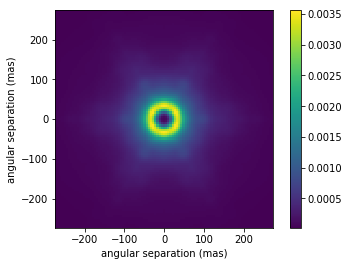

In [9]:
# normalize psf
psf_int = np.sum(x*4*r/r_spot/len(thetas) for x,r in zip(cube, np.repeat(rads, len(thetas))))
fits.writeto(os.path.join(dir_current, 'psf_int.fits'), np.float32(psf_int), overwrite=True)
rad_int = get_radial_profile(psf_int, (int(ndet/2), int(ndet/2)), 1)
I_int = np.sum(psf_int)
print('I_int = %s'%I_int)
lim = int(ncrop/2)*pscale
plt.imshow(crop_img(psf_int, ncrop), origin=True, extent=[-lim, lim, -lim, lim])
plt.xlabel('angular separation (mas)'), plt.ylabel('angular separation (mas)'), plt.colorbar();

### VCG from points beyond ELT pupil's outer edge

In [10]:
print('range = [%s, %s]'%(diam_ext_eff/2, diam_ext_cold_stop/2))
rads = np.arange(diam_ext_eff/2 + r_spot, diam_ext_cold_stop/2 + r_spot, 2*r_spot)
thetas = np.arange(0, 360, 5)
cube = propag_multi_spots(rads, thetas, 'cube_ext.fits')

range = [18.906, 20.472]
radii = [19.006 19.206 19.406 19.606 19.806 20.006 20.206 20.406]
   Load cube from /Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/VCG/cube_ext.fits


I_ext = 12.7775


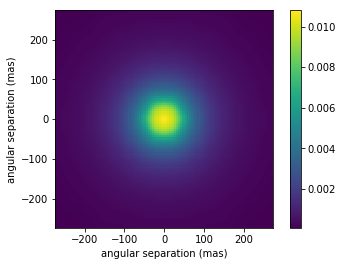

In [11]:
# normalize psf
psf_ext = np.sum(x*4*r/r_spot/len(thetas) for x,r in zip(cube, np.repeat(rads, len(thetas))))
fits.writeto(os.path.join(dir_current, 'psf_ext.fits'), np.float32(psf_ext), overwrite=True)
rad_ext = get_radial_profile(psf_ext, (int(ndet/2), int(ndet/2)), 1)
I_ext = np.sum(psf_ext)
print('I_ext = %s'%I_ext)
plt.imshow(crop_img(psf_ext, ncrop), origin=True, extent=[-lim, lim, -lim, lim])
plt.xlabel('angular separation (mas)'), plt.ylabel('angular separation (mas)'), plt.colorbar();

### VCG from points along spiders

In [12]:
print('range = [%s, %s]'%(diam_int_eff/2, diam_ext_eff/2))
rads = np.arange(diam_int_eff/2 + r_spot, diam_ext_eff/2 - r_spot, 2*r_spot)
thetas = np.arange(30,360,60)
cube = propag_multi_spots(rads, thetas, 'cube_spi.fits')

range = [5.098, 18.906]
radii = [ 5.198  5.398  5.598  5.798  5.998  6.198  6.398  6.598  6.798  6.998
  7.198  7.398  7.598  7.798  7.998  8.198  8.398  8.598  8.798  8.998
  9.198  9.398  9.598  9.798  9.998 10.198 10.398 10.598 10.798 10.998
 11.198 11.398 11.598 11.798 11.998 12.198 12.398 12.598 12.798 12.998
 13.198 13.398 13.598 13.798 13.998 14.198 14.398 14.598 14.798 14.998
 15.198 15.398 15.598 15.798 15.998 16.198 16.398 16.598 16.798 16.998
 17.198 17.398 17.598 17.798 17.998 18.198 18.398 18.598 18.798]
   Load cube from /Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/VCG/cube_spi.fits


I_spi = 19.050556


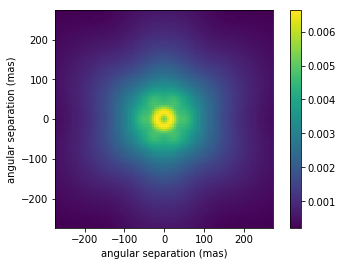

In [13]:
# normalize psf
psf_spi = np.sum(x*2*spi_width/np.pi/r_spot for x in cube)
fits.writeto(os.path.join(dir_current, 'psf_spi.fits'), np.float32(psf_spi), overwrite=True)
rad_spi = get_radial_profile(psf_spi, (int(ndet/2), int(ndet/2)), 1)
I_spi = np.sum(psf_spi)
print('I_spi = %s'%I_spi)
plt.imshow(crop_img(psf_spi, ncrop), origin=True, extent=[-lim, lim, -lim, lim])
plt.xlabel('angular separation (mas)'), plt.ylabel('angular separation (mas)'), plt.colorbar();

### Total VCG from all sources: int + ext + spi

I_all = 35.013016


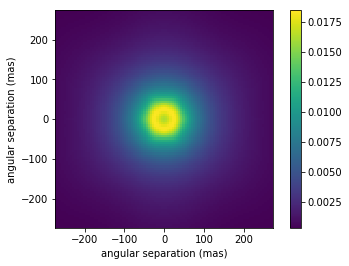

In [14]:
psf_all = psf_int + psf_ext + psf_spi
fits.writeto(os.path.join(dir_current, 'psf_all.fits'), np.float32(psf_all), overwrite=True)
rad_all = get_radial_profile(psf_all, (int(ndet/2), int(ndet/2)), 1)
I_all = np.sum(psf_all)
print('I_all = %s'%I_all)
plt.imshow(crop_img(psf_all, ncrop), origin=True, extent=[-lim, lim, -lim, lim])
plt.xlabel('angular separation (mas)'), plt.ylabel('angular separation (mas)'), plt.colorbar();

### Radial profile

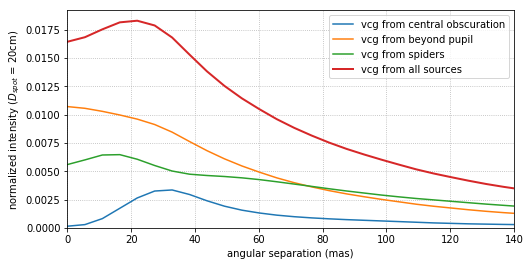

In [15]:
x = np.arange(rad_all.shape[0])*pscale
plt.figure(figsize=(8,4))
plt.plot(x, rad_int, label='vcg from central obscuration')
plt.plot(x, rad_ext, label='vcg from beyond pupil')
plt.plot(x, rad_spi, label='vcg from spiders')
plt.plot(x, rad_all, label='vcg from all sources', linewidth=2)
plt.xlabel('angular separation (mas)'), plt.ylabel('normalized intensity ($D_{spot}$ = 20cm)')
plt.xlim(0, 140), plt.ylim(bottom=0), plt.legend()
plt.grid(True, linestyle=':')
plt.savefig(os.path.join(dir_current, 'vcg_radial_profile.png'), dpi=300, transparent=True);